# Edge Plasma profiles

This notebook demonstrates how to load and visualize edge plasma profiles using the `cherab.imas` interface.
Here, we propose how to visualize edge plasmas with grid meshes defined in the IMAS data structure.

The example test data was calculated by JINTRAC for an ITER 15 MA H-mode scenario.

Prerequisites: [Pooch](https://www.fatiando.org/pooch/) must be installed to download the example data.

In [1]:
import numpy as np
from imas import DBEntry
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm
from rich import print as rprint

from cherab.imas.datasets import iter_jintrac
from cherab.imas.ids.common import get_ids_time_slice
from cherab.imas.ids.common.ggd import load_grid
from cherab.imas.ids.edge_profiles import load_edge_species

# Set dark background for plots
plt.style.use("dark_background")

22:32:21 CRITICAL Could not import 'imas_core': No module named 'imas_core'. Some functionality is not available. @imas_interface.py:34


## Define a function to plot edge plasma profiles

In [2]:
def plot_grid_quantity(
    grid,
    quantity,
    title="",
    clabel="",
    logscale=False,
    symmetric=False,
):
    """Plot a quantity defined on a grid."""
    ax = grid.plot_mesh(data=quantity)

    if logscale:
        # Plot lowest values (mainly 0's) on linear map, as log(0) = -inf.
        linthresh = np.percentile(np.unique(quantity), 1)
        norm = SymLogNorm(
            linthresh=float(max(linthresh, 1.0e-10 * quantity.max())),
            base=10,
        )
        ax.collections[0].set_norm(norm)

    if symmetric:
        vmax = np.abs(quantity.max())
        ax.collections[0].set_clim(-vmax, vmax)
        ax.collections[0].set_cmap("berlin")
    else:
        ax.collections[0].set_cmap("gnuplot")

    ax.set_title(title)
    ax.set_xlabel("$R$ [m]")
    ax.set_ylabel("$Z$ [m]")
    cbar = plt.colorbar(ax.collections[0], ax=ax, aspect=40)
    cbar.set_label(clabel)
    fig = ax.get_figure()
    fig.set_size_inches((4, 6))

    return fig

## Retrieve ITER JINTRAC sample data

In [3]:
path = iter_jintrac()

Output()

## Load grid and species data

### Select grid subset
In "edge_profiles" IDS, there are multiple grid subsets defined.
Here, we choose the `"cells"` subset to visualize the edge plasma profiles.

In [4]:
# Load edge_profiles IDs
with DBEntry(path, "r") as entry:
    ids = get_ids_time_slice(
        entry,
        "edge_profiles",
        time=0,
    )

# Load grid object
grid, subsets, subset_id = load_grid(
    ids.grid_ggd[0],
    with_subsets=True,
)

# Print available grid subsets
rprint("Available grid subsets:", subset_id)

# Extract only "cells" subset
grid = grid.subset(subsets["cells"])

22:32:26 INFO     Parsing data dictionary version 4.1.0 @dd_zip.py:89


22:32:26 INFO     Parsing data dictionary version 4.0.0 @dd_zip.py:89


/tmp/ipykernel_15254/3942360383.py:3: RuntimeWarning: The 'get_slice' method is not implemented for the URI '/home/runner/.cache/cherab/imas/iter_scenario_53298_seq1_DD4.nc'. Falling back to 'get' method to retrieve the entire IDS.
  ids = get_ids_time_slice(


Warning! Unable to verify that the cell nodes are in the winging order.


Available grid subsets:
{
    'cells': np.int32(5),
    'core': np.int32(22),
    'sol': np.int32(23),
    'inner_divertor': np.int32(25),
    'outer_divertor': np.int32(24)
}

### Load edge species data

In [5]:
composition = load_edge_species(
    ids.ggd[0],
    grid_subset_index=subset_id["cells"],
)

Warning! Using average ion temperature for the DT ion.
Warning! Using average ion temperature for the He+1 ion.
Warning! Using average ion temperature for the He+2 ion.
Warning! Using average ion temperature for the Ne(bundle 1) ion.
Warning! Using average ion temperature for the Ne(bundle 5) ion.
Warning! Using average ion temperature for the W(bundle 1) ion.
Warning! Using average ion temperature for the W(bundle 6) ion.
Warning! Using average ion temperature for the Ne(bundle 2) ion_bundle.
Warning! Using average ion temperature for the Ne(bundle 3) ion_bundle.
Warning! Using average ion temperature for the Ne(bundle 4) ion_bundle.
Warning! Using average ion temperature for the W(bundle 2) ion_bundle.
Warning! Using average ion temperature for the W(bundle 3) ion_bundle.
Warning! Using average ion temperature for the W(bundle 4) ion_bundle.
Warning! Using average ion temperature for the W(bundle 5) ion_bundle.


## Plot edge plasma profiles

### Grid mesh

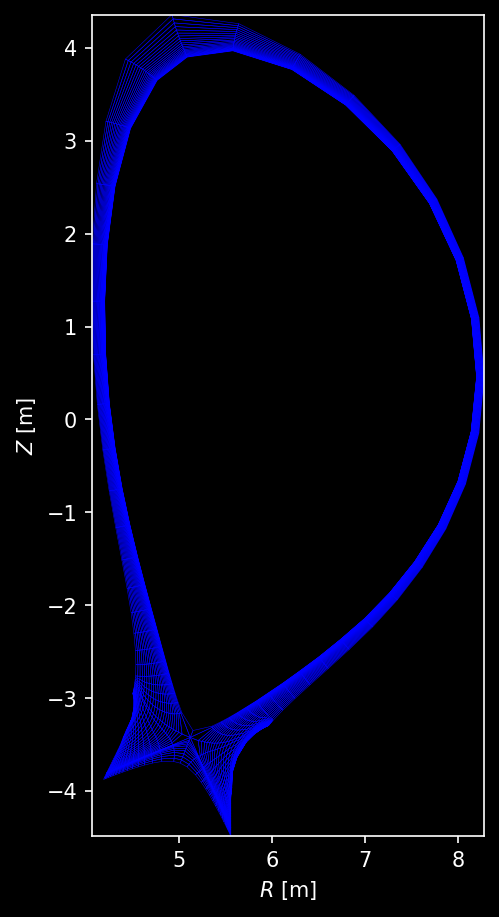

In [6]:
fig, ax = plt.subplots(dpi=150, figsize=(4.0, 6.0), layout="constrained")
ax = grid.plot_mesh(ax=ax)
ax.set_xlabel("$R$ [m]")
ax.set_ylabel("$Z$ [m]");

### Electron profiles

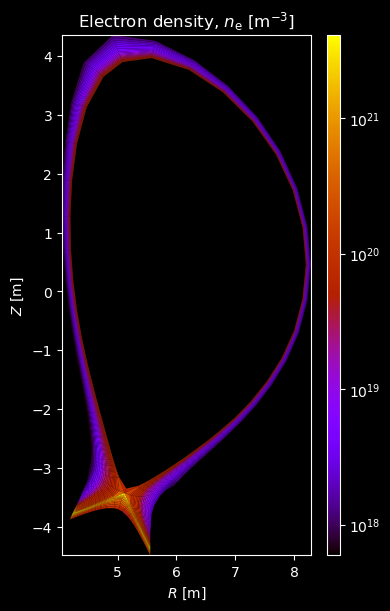

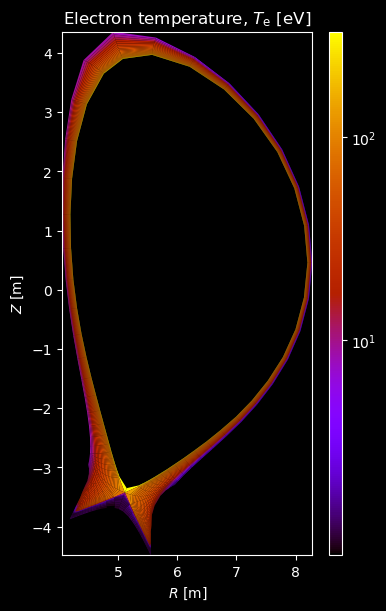

In [7]:
# Electron density
fig = plot_grid_quantity(
    grid,
    composition["electron"]["density"],
    title="Electron density, $n_\\mathrm{e}$ [m$^{-3}$]",
    logscale=True,
)

# Electron temperature
fig = plot_grid_quantity(
    grid,
    composition["electron"]["temperature"],
    title="Electron temperature, $T_\\mathrm{e}$ [eV]",
    logscale=True,
)

### Species profiles

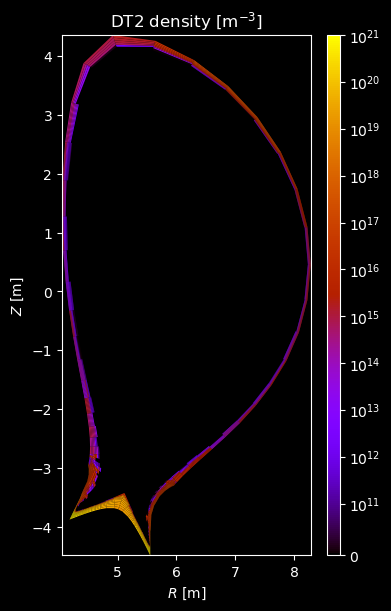

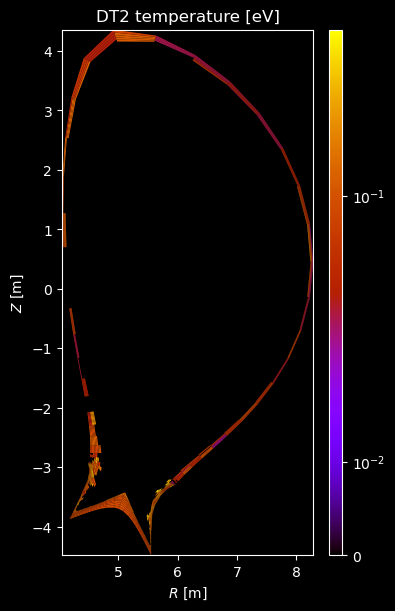

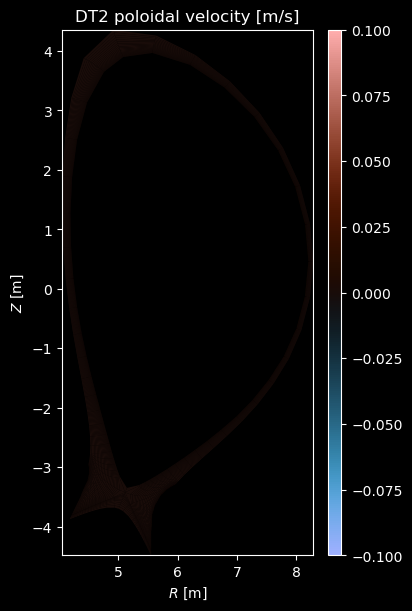

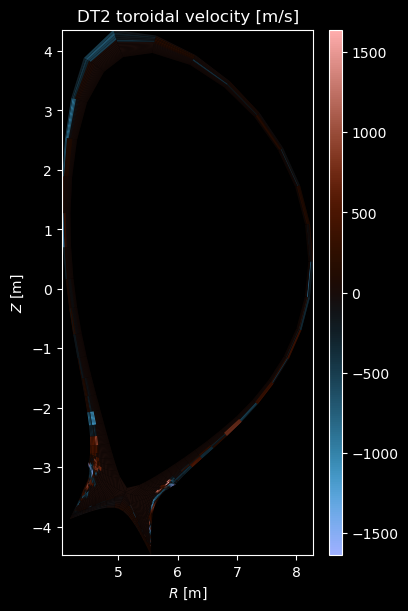

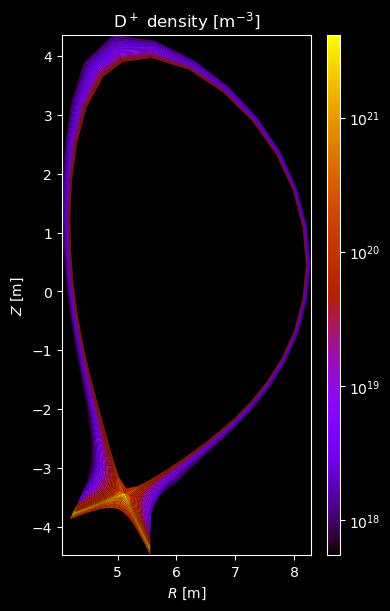

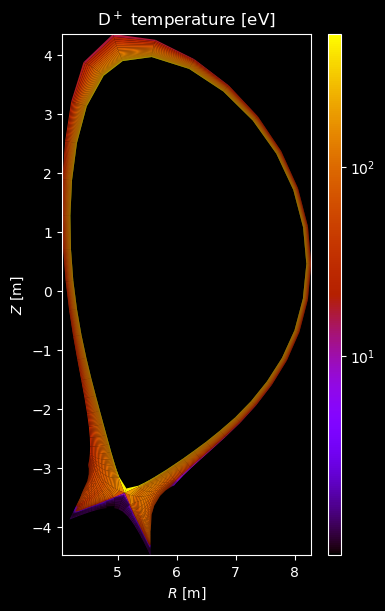

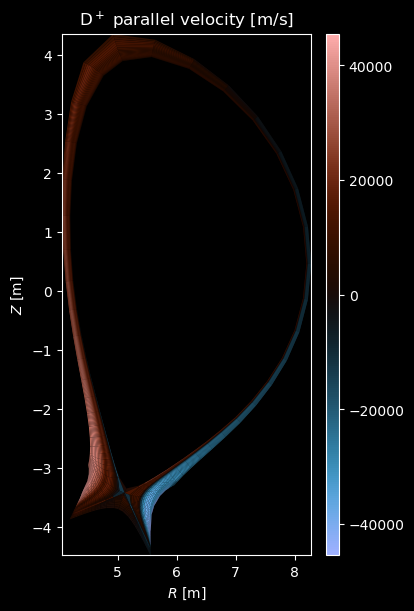

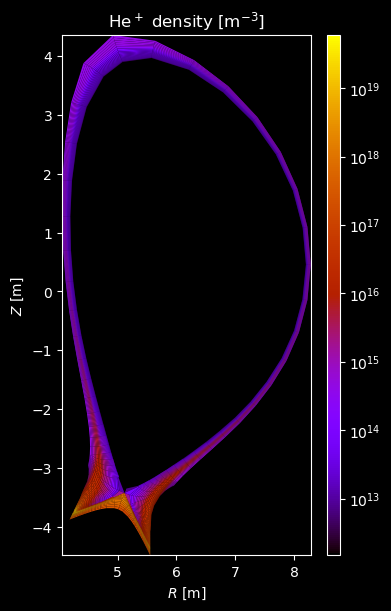

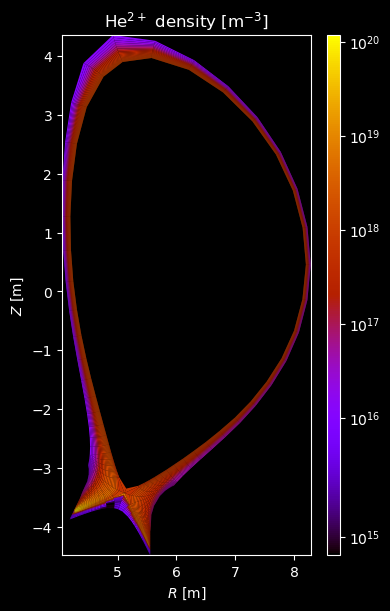

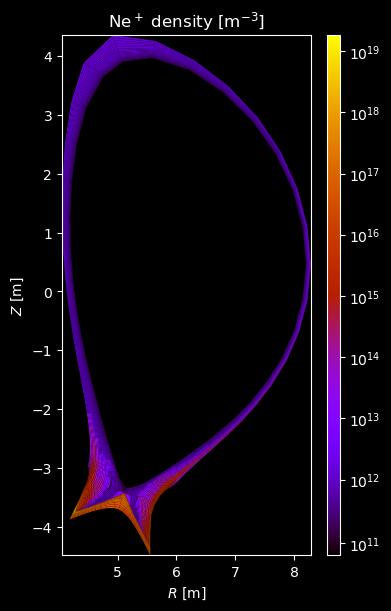

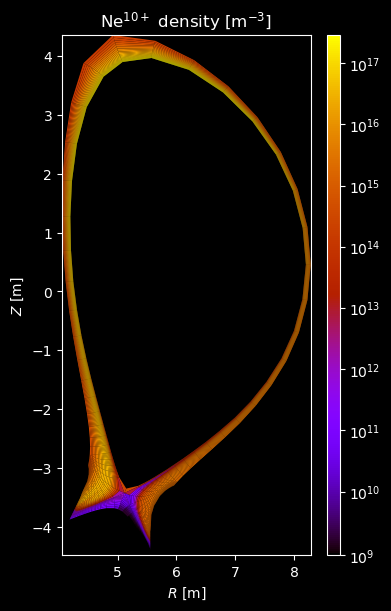

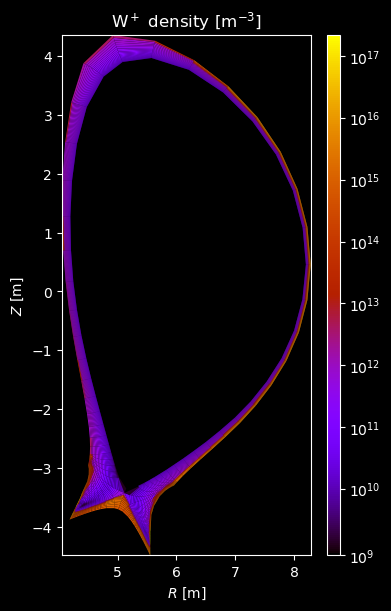

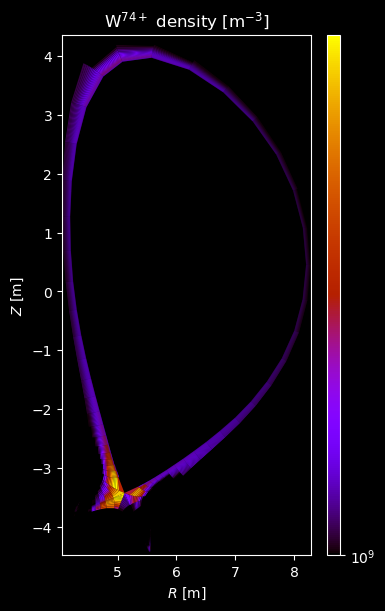

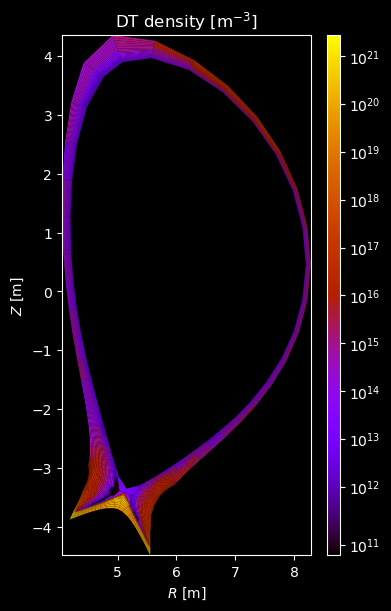

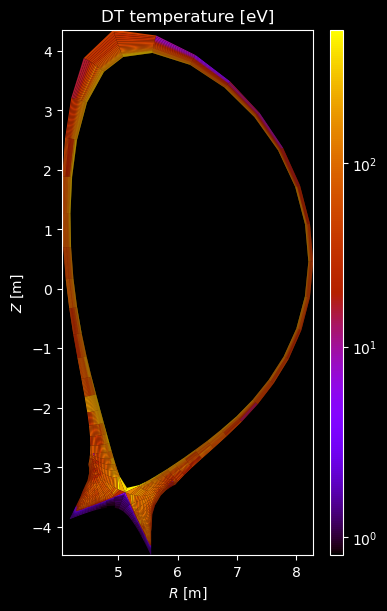

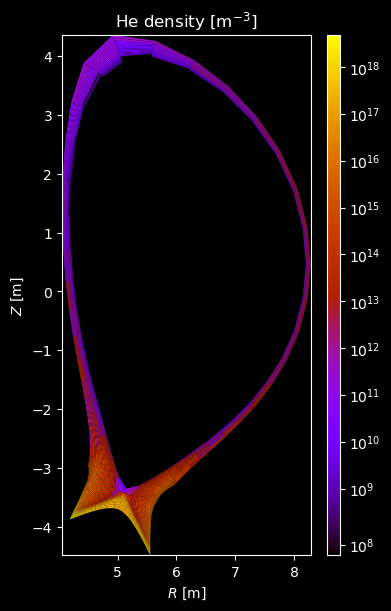

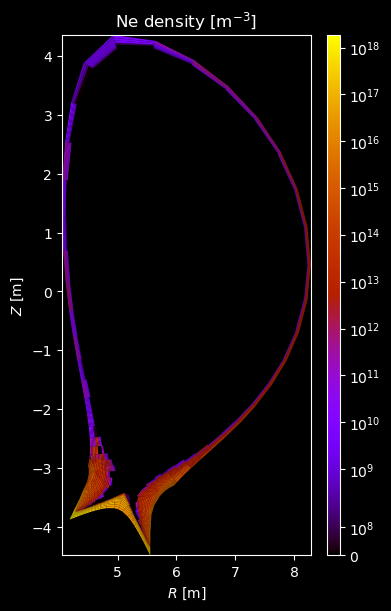

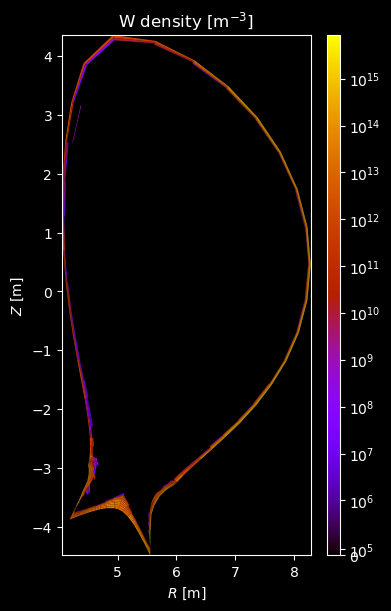

In [8]:
for stype in {"ion", "molecule"}:
    for species_id, profiles in composition[stype].items():
        d = {first: second for first, second in species_id}
        charge = int(round(d["z"]))
        if stype == "ion":
            element = d["element"]
        else:
            element = d["elements"][0]

        if charge == 0:
            name = d["name"]
        elif charge == 1:
            if "+" or "bundle" in d["name"]:
                name = element.symbol
            else:
                name = d["name"]
            name = f"{name}$^+$"
        else:
            if "+" or "bundle" in d["name"]:
                name = element.symbol
            else:
                name = d["name"]
            name = f"{name}$^{{{charge}+}}$"

        # Plot density
        fig = plot_grid_quantity(
            grid,
            profiles["density"],
            title=f"{name} density [m$^{{-3}}$]",
            logscale=True,
        )

        if element.atomic_number == 1:
            # Plot temperature
            temperature = profiles["temperature"]
            if np.any(temperature):
                fig = plot_grid_quantity(
                    grid,
                    profiles["temperature"],
                    title=f"{name} temperature [eV]",
                    logscale=True,
                )

            if charge:
                # Plot velocity profiles
                vpar = profiles["velocity_parallel"]
                if np.any(vpar):
                    fig = plot_grid_quantity(
                        grid,
                        vpar,
                        title=f"{name} parallel velocity [m/s]",
                        symmetric=True,
                    )
            else:
                vrad = profiles["velocity_radial"]
                if np.any(vrad):
                    fig = plot_grid_quantity(
                        grid,
                        vrad,
                        title=f"{name} radial velocity [m/s]",
                        symmetric=True,
                    )
                vpol = profiles["velocity_poloidal"]
                if np.any(vpol):
                    fig = plot_grid_quantity(
                        grid,
                        vrad,
                        title=f"{name} poloidal velocity [m/s]",
                        symmetric=True,
                    )
                vtor = profiles["velocity_phi"]
                if np.any(vtor):
                    fig = plot_grid_quantity(
                        grid,
                        vtor,
                        title=f"{name} toroidal velocity [m/s]",
                        symmetric=True,
                    )